In [283]:
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import seaborn as sns
sns.set()
import scipy.stats as st
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "all"

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

## Data Uploading

In [201]:
df_train = pd.read_csv('train.csv', index_col='Month')
df_train.tail()

,Sunspots
Month,
1939-09,112.6
1939-10,88.1
1939-11,68.1
1939-12,42.1
1940-01,50.5


In [202]:
df_train.shape

(2293, 1)

In [284]:
df_test = pd.read_csv('test.csv')
df_test.head()

,Month,Sunspots
0,1940-01,0
1,1940-02,0
2,1940-03,0
3,1940-04,0
4,1940-05,0


## Modeling

In [204]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(df_train.Sunspots.copy())
data.columns = ["y"]

In [205]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(1, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [206]:
# take a look at the new dataframe 
data.tail(7)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Month,,,,,,,,,,,,,,,,,,,,,
1939-07,97.6,101.0,118.3,109.1,64.6,77.4,80.3,92.7,122.2,99.1,...,101.0,86.5,119.2,98.4,88.8,74.4,124.9,100.7,137.7,145.1
1939-08,105.8,97.6,101.0,118.3,109.1,64.6,77.4,80.3,92.7,122.2,...,127.4,101.0,86.5,119.2,98.4,88.8,74.4,124.9,100.7,137.7
1939-09,112.6,105.8,97.6,101.0,118.3,109.1,64.6,77.4,80.3,92.7,...,97.5,127.4,101.0,86.5,119.2,98.4,88.8,74.4,124.9,100.7
1939-10,88.1,112.6,105.8,97.6,101.0,118.3,109.1,64.6,77.4,80.3,...,165.3,97.5,127.4,101.0,86.5,119.2,98.4,88.8,74.4,124.9
1939-11,68.1,88.1,112.6,105.8,97.6,101.0,118.3,109.1,64.6,77.4,...,115.7,165.3,97.5,127.4,101.0,86.5,119.2,98.4,88.8,74.4
1939-12,42.1,68.1,88.1,112.6,105.8,97.6,101.0,118.3,109.1,64.6,...,89.6,115.7,165.3,97.5,127.4,101.0,86.5,119.2,98.4,88.8
1940-01,50.5,42.1,68.1,88.1,112.6,105.8,97.6,101.0,118.3,109.1,...,99.1,89.6,115.7,165.3,97.5,127.4,101.0,86.5,119.2,98.4


In [207]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [208]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [209]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [210]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [211]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

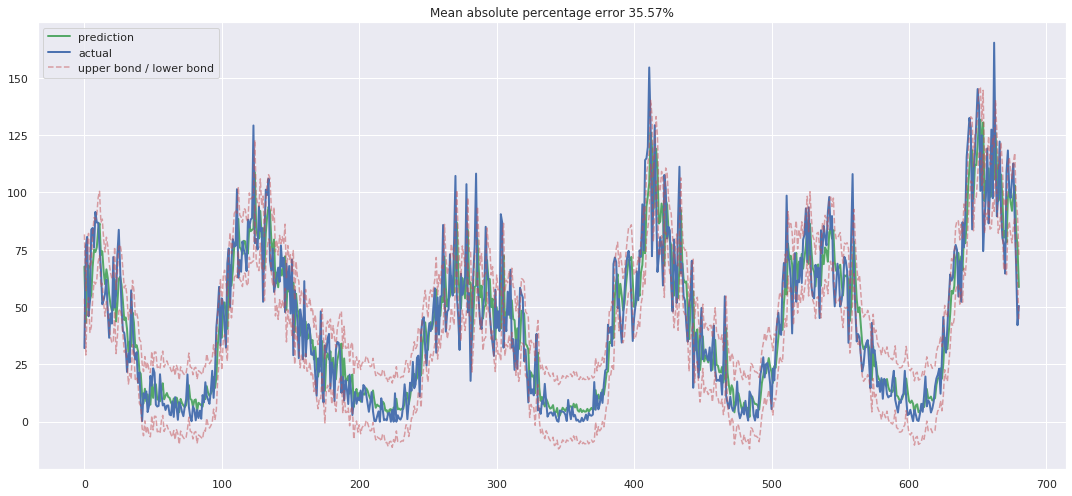

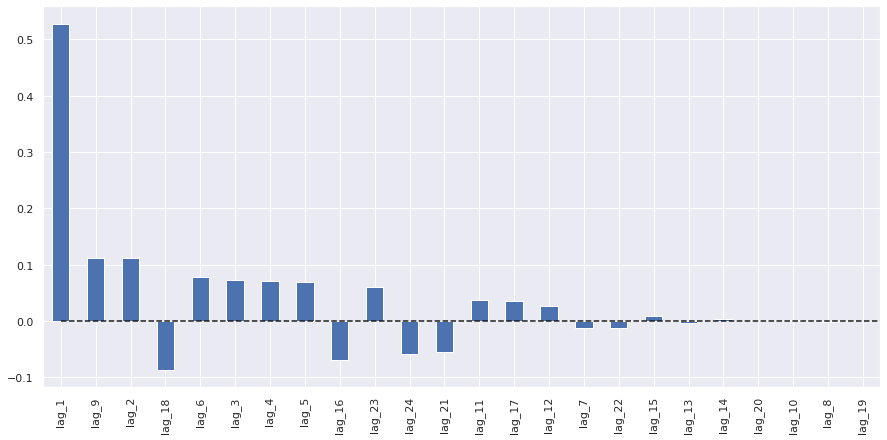

In [212]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [213]:
data.index = pd.to_datetime(data.index)
data["year"] = data.index.year
data.tail()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,year
Month,,,,,,,,,,,,,,,,,,,,,
1939-09-01,112.6,105.8,97.6,101.0,118.3,109.1,64.6,77.4,80.3,92.7,...,127.4,101.0,86.5,119.2,98.4,88.8,74.4,124.9,100.7,1939
1939-10-01,88.1,112.6,105.8,97.6,101.0,118.3,109.1,64.6,77.4,80.3,...,97.5,127.4,101.0,86.5,119.2,98.4,88.8,74.4,124.9,1939
1939-11-01,68.1,88.1,112.6,105.8,97.6,101.0,118.3,109.1,64.6,77.4,...,165.3,97.5,127.4,101.0,86.5,119.2,98.4,88.8,74.4,1939
1939-12-01,42.1,68.1,88.1,112.6,105.8,97.6,101.0,118.3,109.1,64.6,...,115.7,165.3,97.5,127.4,101.0,86.5,119.2,98.4,88.8,1939
1940-01-01,50.5,42.1,68.1,88.1,112.6,105.8,97.6,101.0,118.3,109.1,...,89.6,115.7,165.3,97.5,127.4,101.0,86.5,119.2,98.4,1940


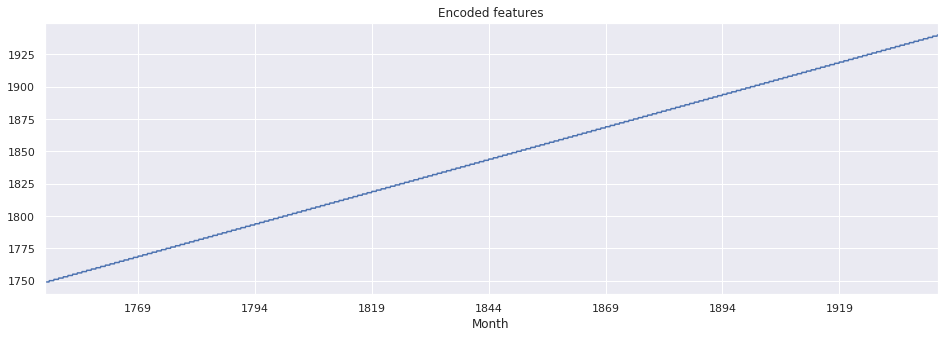

In [214]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.year.plot()
plt.grid(True);

In [215]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

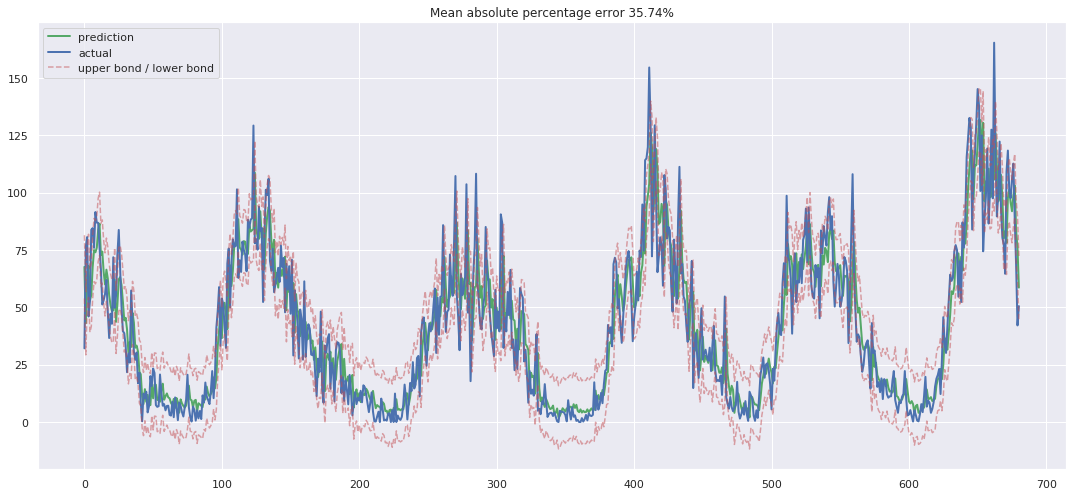

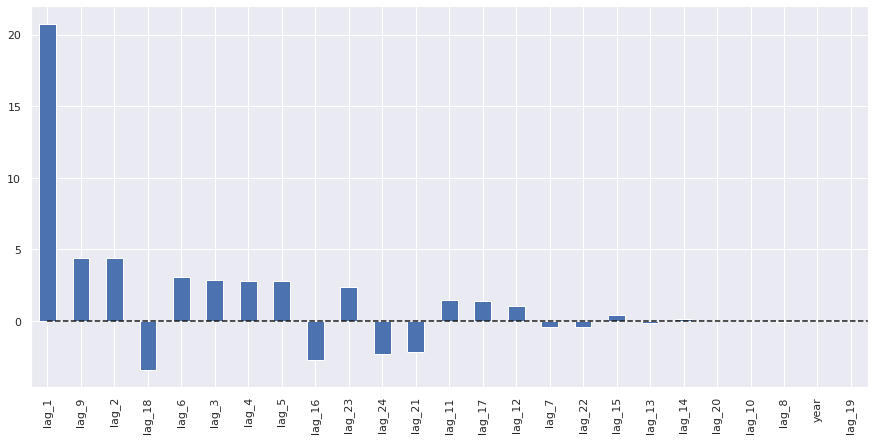

In [216]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [217]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

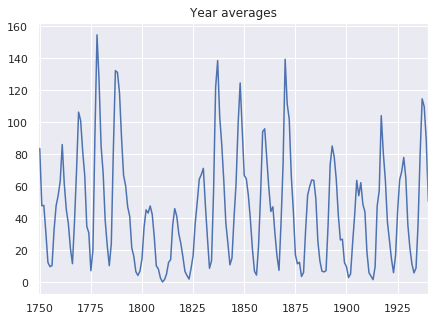

In [218]:
average_hour = code_mean(data, 'year', "y")
plt.figure(figsize=(7, 5))
plt.title("Year averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

In [291]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["year"] = data.index.year
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['year_average'] = list(map(code_mean(data[:test_index], 'year', "y").get, data.year))

        # drop encoded variables 
        data.drop(["year"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X, y, X_train, X_test, y_train, y_test

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

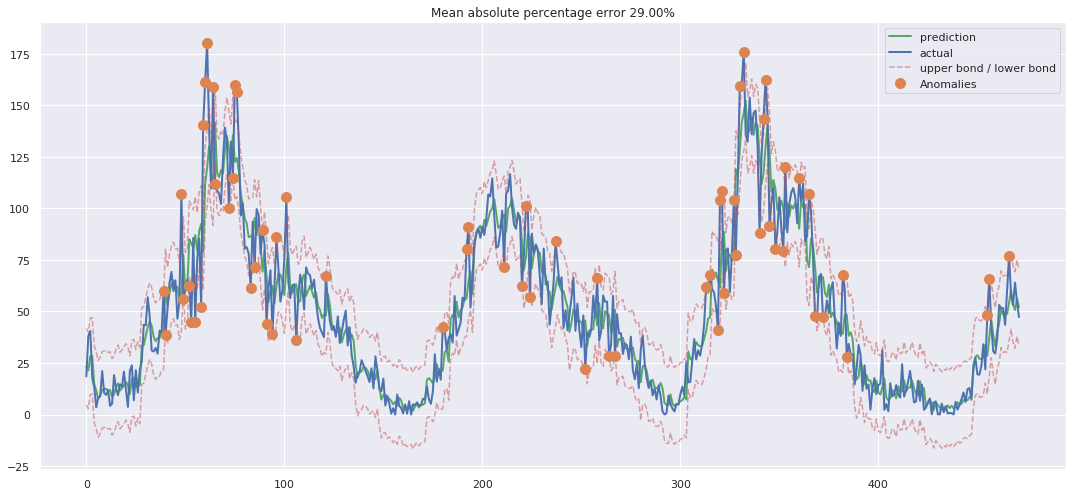

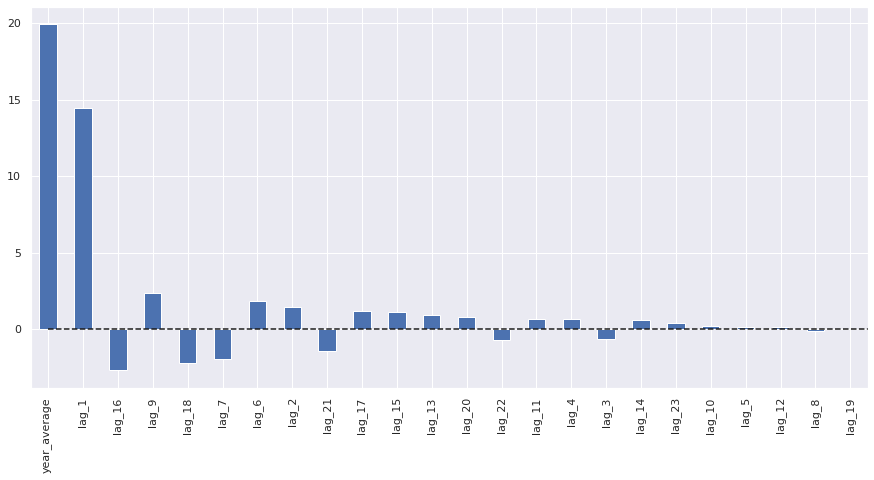

In [292]:
X, y, X_train, X_test, y_train, y_test =\
prepareData(df_train.Sunspots, lag_start=1, lag_end=24, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

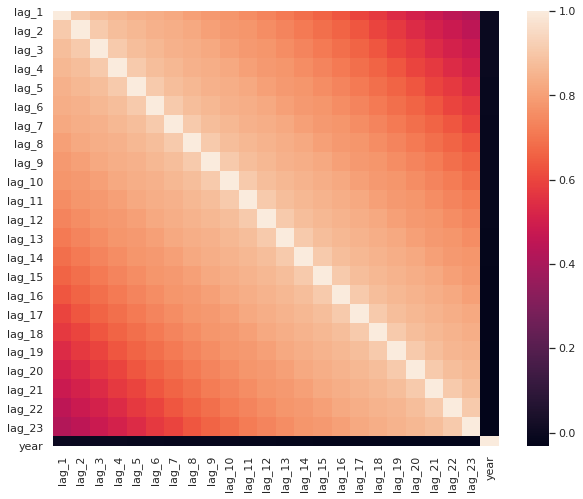

In [240]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

## XGBoost

In [110]:
from xgboost import XGBRegressor 


X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb = XGBRegressor(n_estimators=50, max_depth=20, objective='reg:squarederror')
xgb.fit(X_train_scaled, y_train);

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

## Submission

In [310]:
X_scaled = scaler.fit_transform(X)
lr = LinearRegression()
lr.fit(X, y)
pred = lr.predict(X)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [311]:
pred_final = pd.DataFrame(
    zip(df_test['Month'], pred[-528:]), 
    columns = ['Month', 'Sunspots'])

In [323]:
pred_final.iloc[0,1] = 50.5
pred_final

,Month,Sunspots
0,1940-01,50.500000
1,1940-02,117.683554
2,1940-03,104.319723
3,1940-04,116.373117
4,1940-05,115.672149
...,...,...
523,1983-08,61.122176
524,1983-09,54.543167
525,1983-10,50.760226
526,1983-11,55.838849


In [314]:
pred_final.to_csv('pred_hw12.csv', index=False)

## Averaging

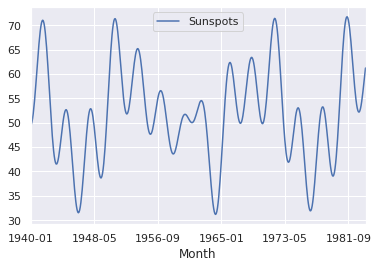

In [346]:
pred_fb = pd.read_csv('pred_hw12-16-2.csv', index_col='Month')
pred_fb.plot()

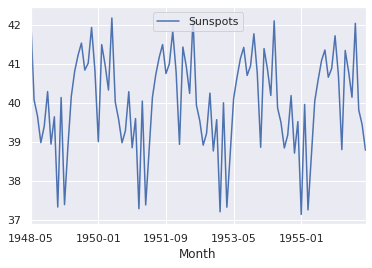

In [340]:
pred_sarimax = pd.read_csv('pred_hw12-17.csv', index_col='Month')
pred_sarimax[100:200].plot()

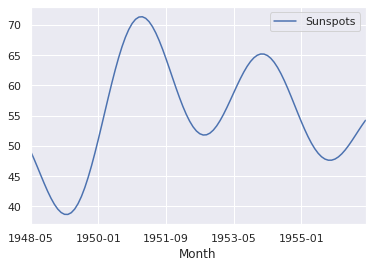

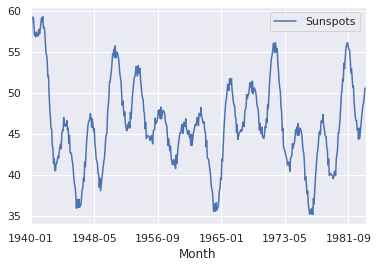

In [345]:
pred_avg = (pred_fb+pred_sarimax)/2
pred_fb[100:200].plot()
pred_avg.plot()

In [303]:
pred_avg.to_csv('pred_hw12.csv', index='Month')